The learning problem is predicting ride prices based on factors like distance, trip duration, time, traffic, weather, and demand.
This problem is better solved with ML because ride pricing patterns are complex, non-linear, and vary dynamically, which fixed rules cannot capture accurately.
The model is expected to learn how each feature influences the ride price and the interactions between them.
It will identify patterns in historical ride data to predict prices for new trips.
The solution enables real-time, adaptive pricing that adjusts to changing conditions automatically.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set visual style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

> I imported libraries for data handling (Pandas, NumPy), visualization (Matplotlib, Seaborn), and machine learning (scikit-learn).
> These tools are used to preprocess data, train regression and classification models, and evaluate their performance.
> I also set a clean, consistent visual style for plots to make data visualizations easier to read.


In [2]:
try:
    df = pd.read_csv('ride_price_dataset_ETB.csv')
    print("✅ Data Loaded Successfully")
    display(df.head())
except FileNotFoundError:
    print("❌ Error: 'ride_price_dataset_ETB.csv' not found.")

✅ Data Loaded Successfully


,distance_km,trip_duration_min,time_of_day,traffic_level,weather_condition,demand_level,peace_level,ride_price_ETB
0,20.43,68,Morning,Low,Rainy,Medium,High,652.74
1,29.00,110,Afternoon,Low,Rainy,Medium,High,912.00
2,3.59,15,Evening,Low,Rainy,Low,High,192.12
3,21.51,70,Evening,High,Rainy,Medium,High,717.18
4,6.94,21,Evening,Low,Rainy,Low,High,267.42


> I attempted to load the dataset from a CSV file using Pandas.
> If the file is found, the data is displayed and a success message is shown.
> If the file is missing, an error message is printed instead.


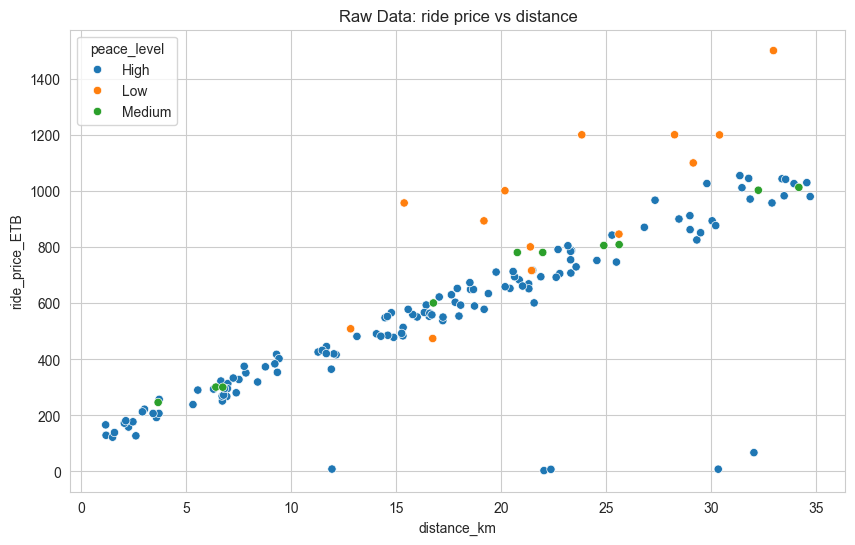

In [3]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_km', y='ride_price_ETB', data=df, hue='peace_level')
plt.title('Raw Data: ride price vs distance')
plt.xlabel('distance_km')
plt.ylabel('ride_price_ETB')
plt.show()

> I created a scatter plot to visualize the relationship between trip distance and ride price.
> Different colors represent different peace levels, helping compare their effect on price.
> This visualization shows the raw data pattern before any modeling or processing.


In [4]:
Q1 = df['ride_price_ETB'].quantile(0.25)
Q3 = df['ride_price_ETB'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['ride_price_ETB'] >= Q1 - 1.5 * IQR) & (df['ride_price_ETB'] <= Q3 + 1.5 * IQR)]

print(f"Data size after cleaning: {df.shape}")

Data size after cleaning: (149, 8)


Missing or incomplete data can cause the model to learn biased or inaccurate patterns.
Noisy or incorrect data (e.g., wrong trip durations or prices) can confuse the model, leading to poor predictions.
                              so
I calculated the first and third quartiles of the ride price to measure data spread.
Using the IQR method, I removed extreme outlier prices from the dataset.
Finally, I printed the dataset size after cleaning to show how many rows remain.

In [5]:
binary_cols = ['weather_condition']
def binary_map(x):
    return x.map({'Clear': 0, 'Rainy': 1})
df[binary_cols] = df[binary_cols].apply(binary_map)



status1 = ['traffic_level']

for col in status1:
   traffic_dummies = pd.get_dummies(df['traffic_level'], prefix='traffic', drop_first=True)
df = pd.concat([df, traffic_dummies], axis=1)
df.drop('traffic_level', axis=1, inplace=True)

status2 = ['time_of_day']

for col in status2:
    time_dummies = pd.get_dummies(df['time_of_day'], prefix='time', drop_first=True)
df = pd.concat([df, time_dummies], axis=1)
df.drop('time_of_day', axis=1, inplace=True)


status3 = ['demand_level']

for col in status3:
    demand_dummies = pd.get_dummies(df['demand_level'], prefix='demand', drop_first=True)
df = pd.concat([df, demand_dummies], axis=1)
df.drop('demand_level', axis=1, inplace=True)


status4 = ['peace_level']

for col in status4:
   peace_dummies = pd.get_dummies(df['peace_level'], prefix='peace', drop_first=True)
df = pd.concat([df, peace_dummies], axis=1)
df.drop('peace_level', axis=1, inplace=True)




I converted the binary weather condition into numerical values (Clear = 0, Rainy = 1).
I applied one-hot encoding to categorical variables (traffic level, time of day, demand level, peace level) to make them usable by ML models.
After encoding, the original categorical columns were removed and replaced with numeric dummy variables.

In [6]:

df['dist_dura'] = df['distance_km'] * df['trip_duration_min']


df['dist_weather'] = df['distance_km'] * df['weather_condition']


df['dist_evening'] = df['distance_km'] * df['time_Evening']
df['dist_night']   = df['distance_km'] * df['time_Night']




D = df[['distance_km']]


print("✅ Features Engineered")

✅ Features Engineered




I created new features by combining distance with trip duration, weather, and time of day to capture interaction effects.
These engineered features help the model understand how distance behaves under different conditions.
Finally, I selected distance-related features and confirmed that feature engineering was completed.

In [7]:
X = df.drop('ride_price_ETB', axis=1)
y = df['ride_price_ETB']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=951)

lm = LinearRegression()
lm.fit(X_train, y_train)

print("✅ Model Trained")

✅ Model Trained


I separated the dataset into input features (X) and the target variable (ride price).
The data was split into training and testing sets to evaluate model performance.
A Linear Regression model was trained using the training data.

   🏆 FINAL MODEL PERFORMANCE 🏆   
R² Score: 0.6627 
MAE:      100.49
MSE:      32,928.72
RMSE:     181.46
MRE:      786.05% 


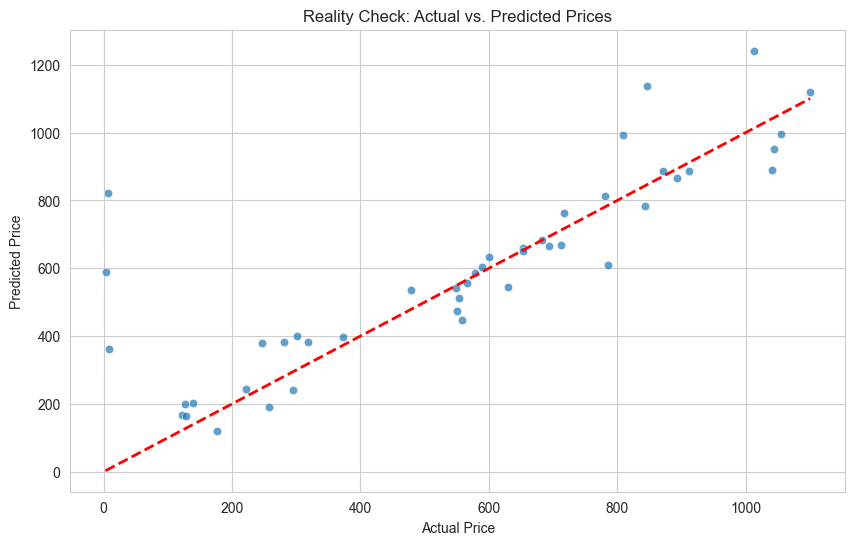

In [8]:
# Make predictions
y_pred = lm.predict(X_test)

# Calculate all metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
epsilon = 1e-8
mre = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100



# Print Report
print("="*40)
print("   🏆 FINAL MODEL PERFORMANCE 🏆   ")
print("="*40)
print(f"R² Score: {r2:.4f} ")
print(f"MAE:      {mae:,.2f}")
print(f"MSE:      {mse:,.2f}")
print(f"RMSE:     {rmse:,.2f}")
print(f"MRE:      {mre:.2f}% ")
print("="*40)

# --- VISUALIZATION: Actual vs Predicted ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
# Draw the perfect prediction line (Red Dashed)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Reality Check: Actual vs. Predicted Prices')
plt.show()

I used your trained model to predict prices on the test data and calculated performance metrics (R², MAE, MSE, RMSE, MRE) to see how accurate it is. Then, I printed a summary report of these metrics. Finally, I visualized actual vs. predicted prices with a scatter plot and a reference line to check prediction quality.

In [9]:
threshold = df['ride_price_ETB'].median()

df['high_cost'] = (df['ride_price_ETB'] > threshold).astype(int)


It calculates the median ride price from your dataset and stores it in threshold.
It creates a new column high_cost that labels each ride as 1 if its price is above the median and 0 otherwise.
Essentially, it’s turning ride prices into a binary feature: high-cost vs low-cost rides.

In [10]:
D = df.drop(['ride_price_ETB', 'high_cost'], axis=1)
C = df['high_cost']


D = df.drop(['ride_price_ETB', 'high_cost'], axis=1) → Creates a feature dataset D by removing the target (ride_price_ETB) and the new label (high_cost) columns.
C = df['high_cost'] → Creates the target/label C, which tells whether a ride is high-cost (1) or not (0).
Basically, I'm preparing D as input features and C as the output label for a classification task.

In [11]:
D_train, D_test, C_train, C_test = train_test_split(
    D, C, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(D_train,C_train)

print("✅ Logistic Regression model trained")

✅ Logistic Regression model trained


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


train_test_split → Splits your data into training (70%) and testing (30%) sets for features (D) and labels (C).
LogisticRegression(max_iter=1000) → Creates a logistic regression model for binary classification and allows enough iterations for convergence.
model.fit(D_train, C_train) → Trains the model on the training data, learning to predict if a ride is high-cost.
The print statement confirms the model is trained.

In [12]:

C_pred = model.predict(D_test)
accuracy = accuracy_score(C_test, C_pred)

print("Accuracy:", accuracy)


Accuracy: 0.9333333333333333


C_pred = model.predict(D_test) → Uses the trained logistic regression model to predict high-cost rides on the test set.
accuracy = accuracy_score(C_test, C_pred) → Calculates the accuracy by comparing the predicted labels (C_pred) with the true labels (C_test).
print("Accuracy:", accuracy) → Displays how well the model is performing on unseen data.

In [13]:
cm = confusion_matrix(C_test, C_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[18  3]
 [ 0 24]]


cm = confusion_matrix(C_test, C_pred) → Computes the **confusion matrix**, which shows how many predictions were correct or wrong for each class (high-cost vs low-cost).
print("Confusion Matrix:\n", cm) → **Displays the matrix**, helping you see true positives, true negatives, false positives, and false negatives.


In [14]:
probs = model.predict_proba(D_test)


probs = model.predict_proba(D_test) → Makes the model output the predicted probabilities for each class (low-cost = 0, high-cost = 1) instead of just the final label.

Essentially, it tells me how confident the model is that a ride belongs to each class

In [15]:
for i in range(len(probs)):
    print(
        f"Ride {i+1}: "
        f"Low = {probs[i][0]:.2f}, "
        f"High = {probs[i][1]:.2f}"
    )


Ride 1: Low = 1.00, High = 0.00
Ride 2: Low = 0.23, High = 0.77
Ride 3: Low = 1.00, High = 0.00
Ride 4: Low = 0.17, High = 0.83
Ride 5: Low = 0.01, High = 0.99
Ride 6: Low = 0.79, High = 0.21
Ride 7: Low = 1.00, High = 0.00
Ride 8: Low = 0.03, High = 0.97
Ride 9: Low = 0.00, High = 1.00
Ride 10: Low = 0.57, High = 0.43
Ride 11: Low = 1.00, High = 0.00
Ride 12: Low = 1.00, High = 0.00
Ride 13: Low = 0.75, High = 0.25
Ride 14: Low = 1.00, High = 0.00
Ride 15: Low = 0.53, High = 0.47
Ride 16: Low = 0.01, High = 0.99
Ride 17: Low = 0.03, High = 0.97
Ride 18: Low = 1.00, High = 0.00
Ride 19: Low = 0.62, High = 0.38
Ride 20: Low = 0.01, High = 0.99
Ride 21: Low = 0.01, High = 0.99
Ride 22: Low = 0.01, High = 0.99
Ride 23: Low = 0.00, High = 1.00
Ride 24: Low = 0.14, High = 0.86
Ride 25: Low = 0.01, High = 0.99
Ride 26: Low = 0.01, High = 0.99
Ride 27: Low = 1.00, High = 0.00
Ride 28: Low = 0.00, High = 1.00
Ride 29: Low = 0.06, High = 0.94
Ride 30: Low = 0.03, High = 0.97
Ride 31: Low = 0.01

Iterates over each test ride in probs.
Prints the predicted probability for that ride being low-cost (0) and high-cost (1), rounded to 2 decimals.
Lets you see how confident the model is for each individual prediction.
It’s basically giving a detailed confidence report for every ride